In [18]:
import numpy as np
import frugal_rationality.LQG_control as lqg
import frugal_rationality.nonlinear_simulation as sims
import frugal_rationality.visualizer as viz
import frugal_rationality.numerical_solver as solver

# Drone hovering at target position

In [2]:
# =================================================================================
# Task description
# =================================================================================

# System parameters
m = 0.775            # mass of drone
l = 0.15             # arm length
I = 2* m * l**2      # Moment of inertia
g = 9.8              # gravity force
dt = 0.01            # time step for time discretization

# World state (s):
# x := x position
# v_x := x velocity
# y := y position
# v_y := y velocity
# tilt := inclination with respect to the x-axis
# v_tilt := tilt (angular) velocity
state_dimensions = ["x", "v_x", "y", "v_y", "tilt", "v_tilt"]

# Actions:
# [u0, u1] := adjustments to 2 propellers

# Signal-to-noise ratio:
# Accurate measurements of positions, unreliable measurements of velocities
SNR = np.array([2., .5, 2., .5, 2., .5])

# Cost function:
# Agent's goal: keeping drone hovering near a target position (x=0, y=0, tilt=0)
# State deviation penalty: Cost per unit of deviation along the state dimensions
Cx = (1/dt) * np.diag([10., .5, .5, .5, 10., .5])
# Motion penalty: Cost per unit of motion
Cu = (1/dt) * np.diag([1., 1.])
# Inference penalty: Cost per bit of information gained through inference
cn = 5

# =================================================================================
# Motion dynamics are nonlinear but admit linearization nearby the target state
#
# s_t = A s_{t-1} + B u_{t-1} + w_{t-1}      ; w is white Gaussian noise with covariance Q
# o_t = H s_{t-1} + v_{t-1}                  ; v is white Gaussian noise with covariance R

# Transition dynamics
A = np.array([
    [1., dt, 0., 0.,     0.,   0.],
    [0., 1., 0., 0., -dt * g,  0.],
    [0., 0., 1., dt,     0.,   0.],
    [0., 0., 0., 1.,     0.,   0.],
    [0., 0., 0., 0.,     1.,   dt],
    [0., 0., 0., 0.,     0.,   1.]
])

# Motor responsiveness
B = np.array([[0., 0.], [0., 0.], [0., 0.], [dt/m, dt/m], [0., 0.], [dt * l / I, - dt * l / I]])

# Observation matrix
H = np.eye(6)

# Process noise covariance
Q = .01 * np.eye(6) * dt
# Observation noise covariance
R = Q / SNR

## 1. Baseline performance (optimal solution when information is free)

Expected performance: 
state cost = 21.07, action cost = 8.36, bits = 4.68


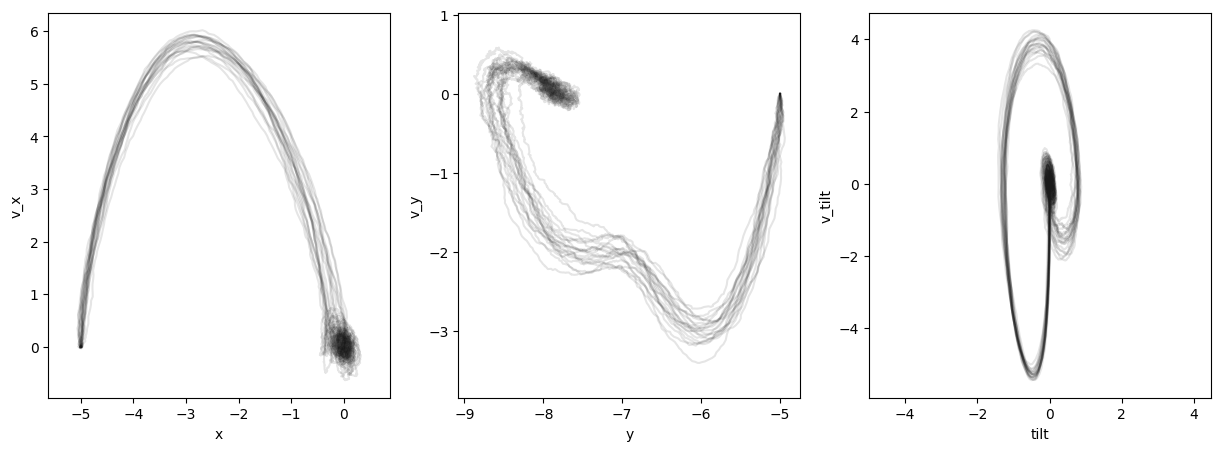

In [3]:
# 1.1 Solve the problem via LQG
LQG_strategy = lqg.solve(A, B, H, Q, R, Cx, Cu)
print(f"Expected performance: \nstate cost = {LQG_strategy['state_cost']:.2f}, action cost = {LQG_strategy['action_cost']:.2f}, bits = {LQG_strategy['bits']:.2f}")

# 1.2 Create environment, simulate, and visualize trajectories
env = sims.PlanarDrone(m, l, g, dt)
noise_cov = [Q, R]

N = 20
T = 10
horizon = int(T/dt)

init_s = np.array([-5., 0., -5., 0., 0 * np.pi / 180, 0])
init_u = np.array([m * g/2, m * g / 2])

s0, u0 = sims.nonlinear_sim(env, LQG_strategy, noise_cov, init_s, init_u, dt, horizon, N, lqg=True)

LQG_figures = viz.state_space_trajectories(s0, state_dimensions, 0, T, dt, figsize=(15, 5))

## 2. Frugal performance (optimal solution when information is costly)

In [4]:
# 2.0 [Optional] Load an existing solution
frugal_params = np.load("../solutions/drone.npy")
frugal_strategy = solver.readSol(A, B, H, Q, R, Cx, Cu, cn, params = frugal_params)
print(f"Expected performance: \nstate cost = {frugal_strategy['state']:.2f}, action cost = {frugal_strategy['action']:.2f}, bits = {frugal_strategy['bits']:.2f}")

Expected performance: 
state cost = 22.39, action cost = 10.41, bits = 1.21


In [ ]:
# 2.1 Compute solution from scratch

# Use LQG solution as initialization
LQG_strategy = lqg.solve(A, B, H, Q, R, Cx, Cu)
Psi = LQG_strategy['L'] @ LQG_strategy['K']
Pi = LQG_strategy['L'] @ LQG_strategy['G'] @ np.linalg.pinv(LQG_strategy['L'])

# Run solver
frugal_params, loss, success = solver.minimize(A, B, H, Q, R, Cx, Cu, cn, [Psi, Pi],
                                  learning_rate=.001, max_steps=200000, hess_step=1e-6)

# Read solution
frugal_strategy = solver.readSol(A, B, H, Q, R, Cx, Cu, cn, params = frugal_params)

In [25]:
# [Optional] Save solution
# np.save("../solutions/drone.npy", frugal_params)

# Compare Performance between unconstrained and frugal strategy
print(f"Expected performance (LQG): \nstate cost = {LQG_strategy['state_cost']:.2f}, action cost = {LQG_strategy['action_cost']:.2f}, bits = {LQG_strategy['bits']:.2f}")

print(f"Expected performance (frugal): \nstate cost = {frugal_strategy['state']:.2f}, action cost = {frugal_strategy['action']:.2f}, bits = {frugal_strategy['bits']:.2f}")

Expected performance (LQG): 
state cost = 21.07, action cost = 8.36, bits = 4.68
Expected performance (frugal): 
state cost = 22.30, action cost = 10.48, bits = 1.22


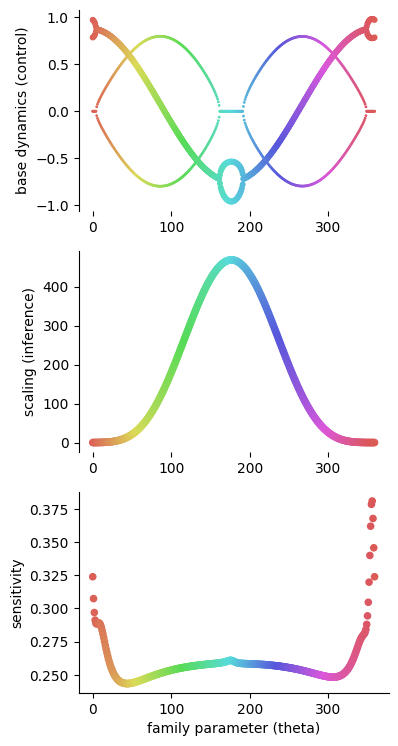

In [26]:
# 2.2 Recover the complete solution family
family = solver.getFamily(A, B, H, Q, R, Cx, Cu, cn, frugal_strategy, members=360)

# 2.3 Visualize characteristics of family members
data = solver.characterizeFamily(A, B, H, Q, R, Cx, Cu, cn, dt, m, l, family)
viz.props_family(data, figsize=(4, 12))

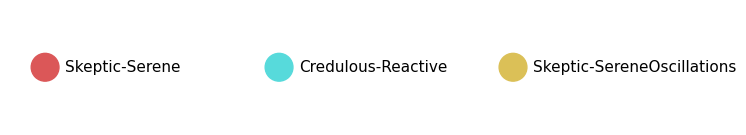

In [27]:
# Special members
labels = ['Skeptic-Serene', 'Credulous-Reactive', 'Skeptic-SereneOscillations']
members_to_viz = [np.argmin(data.obs_scaling),          # Skeptic-Serene
                  np.argmax(data.obs_scaling),          # Credulous-Reactive
                  np.argmin(data.sensitivity_loss)]     # Skeptic-SereneOscillations, Best adaptation

viz.displaySpecialMembers(members_to_viz, labels)

[np.int64(356), np.int64(177), np.int64(44)]


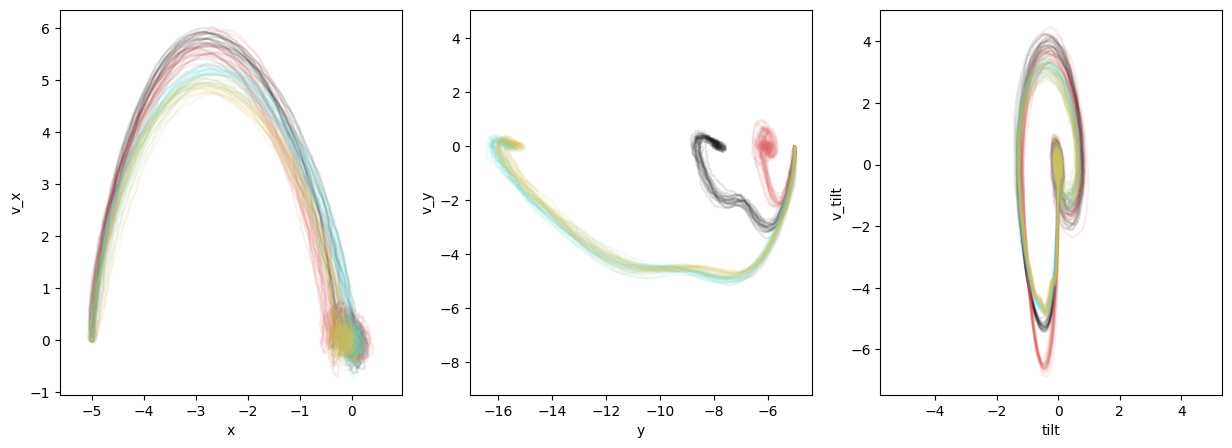

In [28]:
# 2.3 Run simulations and visualize special trajectories
print(members_to_viz)
s, u = [], []
start, stop = 0, T
figures = LQG_figures
for i, id_member in enumerate(members_to_viz):
    member = family[id_member]
    states, actions = sims.nonlinear_sim(env, member, noise_cov, init_s, init_u, dt, horizon, N)
    s.append(states)
    u.append(actions)
    figures = viz.state_space_trajectories(states, state_dimensions, start, stop, dt, 'drone', id_color=id_member, figures=figures)

# Display figure
figures[0]

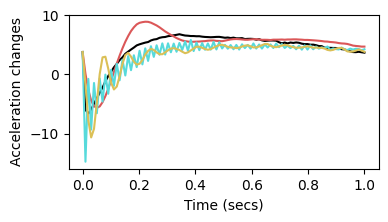

In [29]:
# 2.4 Visualize action trajectories (one trial)

start, stop = 0, 1
trial_id = 0

# Adjustments to left propeller
action_dim = 0
sample_trajectories = [u0[:, action_dim, trial_id]]
for actions in u:
    sample_trajectories.append(actions[:, action_dim, trial_id])
viz.action_trajectories(sample_trajectories, members_to_viz, 'drone', start, stop, dt)

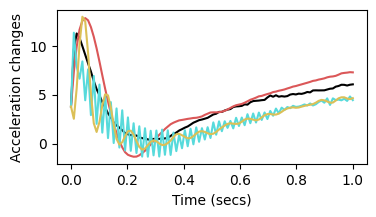

In [30]:
# Adjustments to right propeller
action_dim = 1
sample_trajectories = [u0[:, action_dim, trial_id]]
for actions in u:
    sample_trajectories.append(actions[:, action_dim, trial_id])
viz.action_trajectories(sample_trajectories, members_to_viz, 'drone', start, stop, dt)

In [31]:
renderer = viz.SimpleMultiDroneRenderer()
renderer.animate([s[0][:, :, 0], s[1][:, :, 0], s[2][:, :, 0], s0[:, :, 0]], dt,
                 identities=members_to_viz,
                 save_path="../render_demos/drone.gif", realtime=False)